In [1]:
import numpy as np
import scipy as sc
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import bijectors as tfb
from scipy import io
import time
import matplotlib.pyplot as plt
from sklearn import mixture
import joblib as jbl
import sys
from fitter import Fitter
sys.path.append('C:/Users/tewar/Documents/work/BNAF-master/data/')

In [16]:
# finite different gradient
def gradientFiniteDifferent(func,theta,delta=1E-8):
    n = np.size(theta)
    grad = np.zeros((n))
    for i in range(n):
        theta_p=np.copy(theta)
        theta_m=np.copy(theta)
        theta_p[i]=theta_p[i]+delta
        theta_m[i]=theta_m[i]-delta
        f_plus = func(tf.constant(theta_p,dtype=tf.float64)).numpy()
        f_minus = func(tf.constant(theta_m,dtype=tf.float64)).numpy()
        grad[i] = (f_plus-f_minus)/(2*delta)
    return grad

def GMM_best_fit(samples,max_ncomp=10, print_info=False):
    lowest_bic = np.infty
    bic = []
    for n_components in np.arange(8,max_ncomp):
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components+1,covariance_type='full',max_iter=200,n_init=5)
        gmm.fit(samples)
        if print_info:
            print('Fittng a GMM on samples with %s components: BIC=%f'%(n_components,gmm.bic(samples)))
        bic.append(gmm.bic(samples))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm    
    return best_gmm

# Numerically finding the icdf values for a distribution whos analytical CDF is specified
def icdf_numerical(u,cdf_funct,lb,ub):
    # setting up the numerical method (Chandrupatla root finding algorithm) to find icdf
    obj_func = lambda x: cdf_funct(x) - u
    # finding the roots
    x = tfp.math.find_root_chandrupatla(obj_func,low=lb,high=ub)[0]
    return x

# Standardize GMM parameters
def standardize_gmm_params(alphas,mus,covs):
    weighted_mus = tf.linalg.matvec(tf.transpose(mus),alphas)
    new_mus = mus - weighted_mus
    variances = tf.linalg.diag_part(covs)
    scaling_vec = tf.linalg.matvec(tf.transpose(new_mus**2+variances),alphas)
    scaling_matrix = tf.linalg.diag(1/(scaling_vec**0.5))
    new_mus = tf.linalg.matmul(new_mus,scaling_matrix)
    new_covs = tf.linalg.matmul(covs,scaling_matrix**2)
    return alphas,new_mus,new_covs

# Function to compute numerical gradient using central finite difference
def gradientFiniteDifferent(func,theta,delta=1E-4):
    n = np.size(theta)
    grad = np.zeros((n))
    for i in range(n):
        theta_p=np.copy(theta)
        theta_m=np.copy(theta)
        theta_p[i]=theta_p[i]+delta
        theta_m[i]=theta_m[i]-delta
        f_plus = func(tf.constant(theta_p,dtype=tf.float32)).numpy()
        f_minus = func(tf.constant(theta_m,dtype=tf.float32)).numpy()
        grad[i] = (f_plus-f_minus)/(2*delta)
    return grad

def vec2gmm_params(n_dims,n_comps,param_vec):
    num_alpha_params = n_comps
    num_mu_params = n_comps*n_dims
    num_sig_params = int(n_comps*n_dims*(n_dims+1)*0.5)
    logit_param, mu_param, chol_param = tf.split(param_vec,[num_alpha_params,num_mu_params,num_sig_params])
    mu_vectors = tf.reshape(mu_param, shape=(n_comps,n_dims))
    chol_mat_array=tf.TensorArray(tf.float32,size=n_comps)
    cov_mat_array=tf.TensorArray(tf.float32,size=n_comps)
    for k in range(n_comps):
        start_idx = tf.cast(k*(num_sig_params/n_comps),tf.int32)
        end_idx = tf.cast((k+1)*(num_sig_params/n_comps),tf.int32)
        chol_mat = tfb.FillScaleTriL(diag_bijector=tfb.Exp()).forward(chol_param[start_idx:end_idx])
        cov_mat = tf.matmul(chol_mat,tf.transpose(chol_mat))
        chol_mat_array = chol_mat_array.write(k,chol_mat) 
        cov_mat_array =  cov_mat_array.write(k,cov_mat) 
        
    chol_matrices = chol_mat_array.stack()
    cov_matrices = cov_mat_array.stack()     
    return [logit_param,mu_vectors,cov_matrices,chol_matrices]

def gmm_params2vec(n_dims,n_comps,alphas,mu_vectors,cov_matrices):
    # now gathering all the parameters into a single vector
    param_list = []
    param_list.append(np.log(alphas))
    param_list.append(tf.reshape(mu_vectors,-1))
    for k in range(n_comps):
        chol_mat = tf.linalg.cholesky(cov_matrices[k])
        param_list.append(tfb.FillScaleTriL(diag_bijector=tfb.Exp()).inverse(chol_mat))
    param_vec = tf.concat(param_list,axis=0)
    return param_vec

In [4]:
# GMC bijector
class GMC_bijector(tfb.Bijector):
    def __init__(self,n_dims,n_comps,param_list,forward_min_event_ndims=1, validate_args: bool = False,name="gmc"):
        super(GMC_bijector, self).__init__(
            validate_args=validate_args, forward_min_event_ndims=forward_min_event_ndims, name=name
        )
        
        assert (len(param_list)==3), 'incorrect number of inputs'
        assert param_list[1].shape == [n_comps,n_dims], 'the dimension of mean vectors should be ncomps x ndims'
        assert param_list[2].shape == [n_comps,n_dims], 'the dimension of variance vectors should be ncomps x ndims'
        
        self.ndims = n_dims
        self.ncomps = n_comps
        self.logits = param_list[0]
        self.mu_vectors = param_list[1]
        self.var_vectors = param_list[2]
        self.std_vectors = self.var_vectors**0.5
    
    def _forward(self, x_mat):
        assert x_mat.shape[1] == self.ndims, 'expected data dimensions n_samps x n_dims'
        dist = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(logits=self.logits),
                               components_distribution=tfd.Normal(loc=tf.transpose(self.mu_vectors),
                                                                  scale=tf.transpose(self.std_vectors)))
        u_mat = dist.cdf(x_mat)
        return u_mat
    
    def _inverse(self, u_mat):
        assert u_mat.shape[1] == self.ndims, 'expected data dimensions n_samps x n_dims'
        x_mat = self.gmm_icdf_parallel(u_mat,self.logits,tf.transpose(self.mu_vectors),tf.transpose(self.std_vectors))
        return x_mat
    
    def _inverse_log_det_jacobian(self, u_mat):
        x_mat = self._inverse(u_mat)
        dist = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(logits=self.logits),
                               components_distribution=tfd.Normal(loc=tf.transpose(self.mu_vectors),
                                                                  scale=tf.transpose(self.std_vectors)))
        log_det_J_mat = dist.log_prob(x_mat)
        return -tf.reduce_sum(log_det_J_mat,axis=1)    
    
    # Numerically finding the icdf values of univariate gmm distributions (one along each dimension)
    @tf.custom_gradient
    def gmm_icdf_parallel(self,u_mat,logit,mu_T,std_T):
        # Setting up the numerical method to find icdf
        # first define a function that computes the residual between the actual true CDF values and the CDF value as specified matrix
        obj_func = lambda x: tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(logits=logit),
                                                   components_distribution=tfd.Normal(loc=mu_T,scale=std_T)).cdf(x)-u_mat
        # specifying the lower and upper bounds of the root based on current parameters
        lb = tf.reduce_min(mu_T,axis=1) - 5*tf.reduce_max(std_T,axis=1)
        ub = tf.reduce_max(mu_T,axis=1) + 5*tf.reduce_max(std_T,axis=1)
        # replicating the lower and upper bounds
        lb = tf.repeat(tf.reshape(lb,[1,-1]),u_mat.shape[0],axis=0)
        ub = tf.repeat(tf.reshape(ub,[1,-1]),u_mat.shape[0],axis=0)
        # finding the roots (Chandrupatla root finding algorithm)
        x_mat = tfp.math.find_root_chandrupatla(obj_func,low=lb,high=ub)[0]
        # following code implements custom gradient
        def grad(dy):
            # Calling  another python function to get the partial derivatives
            grad_logit, grad_mu, grad_std = self.partial_deriv_z(x_mat,logit,mu_T,std_T)

            temp_mat = tf.linalg.matmul(grad_logit,dy)

            logit_grad = tf.linalg.diag_part(temp_mat)
            logit_grad = tf.reduce_sum(logit_grad,axis=1)

            temp_mat = tf.linalg.matmul(grad_mu,dy)
            mu_grad = tf.linalg.diag_part(temp_mat)

            temp_mat = tf.linalg.matmul(grad_std,dy)
            std_grad = tf.linalg.diag_part(temp_mat)
            
            return tf.constant(0.,shape=(u_mat.shape)), logit_grad, tf.transpose(mu_grad), tf.transpose(std_grad)    
        return x_mat, grad
    
    # Analytical partial derivative of icdf of Gaussian Mixture marginals
    def partial_deriv_z(self,z,logit,mu_T,std_T):
        alpha = tf.math.softmax(logit)
        grad_logit_array = tf.TensorArray(tf.float32, size=self.ncomps)
        grad_mu_array = tf.TensorArray(tf.float32, size=self.ncomps)
        grad_var_array = tf.TensorArray(tf.float32, size=self.ncomps)        
        dist = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(logits=logit),
                                components_distribution=tfd.Normal(loc=mu_T,
                                                                   scale=std_T))
        common_factor1 = dist.prob(z)
        for k in range(self.ncomps):        
            common_factor2 = tfd.Normal(loc=mu_T[:,k],scale=std_T[:,k]).prob(z)
            term = 0.5*(1+tf.math.erf((z-mu_T[:,k])/(tf.math.sqrt(2.)*std_T[:,k])))
            v1 = -alpha[k]*(term - dist.cdf(z))/common_factor1
            v2 = alpha[k]*common_factor2/common_factor1
            v3 = v2 * ((z-mu_T[:,k])/(std_T[:,k])) 

            grad_logit_array = grad_logit_array.write(k, tf.transpose(v1) )
            grad_mu_array = grad_mu_array.write(k, tf.transpose(v2) )
            grad_var_array = grad_var_array.write(k, tf.transpose(v3) )
        return grad_logit_array.stack(), grad_mu_array.stack(), grad_var_array.stack()
    
 # Marignal transform bijector
class Marginal_transform(tfb.Bijector):
    def __init__(self,ndims,marg_dist_list,forward_min_event_ndims=1, validate_args: bool = False,name="marginals"):
        super(Marginal_transform, self).__init__(
            validate_args=validate_args, forward_min_event_ndims=forward_min_event_ndims, name=name
        )
        self.ndims = ndims
        self.marg_dists = marg_dist_list
    
    def _inverse(self, x_mat):
        nobs = x_mat.get_shape().as_list()[0]
        temp_array = tf.TensorArray(tf.float32,size=self.ndims)
        for j in range(self.ndims):
            u_cur = self.marg_dists[j]['cdf'](x_mat[:,j])
            temp_array = temp_array.write(j,u_cur)
        u_mat = tf.transpose(temp_array.stack())            
        return u_mat
    
    def _forward(self, u_mat):
        temp_array = tf.TensorArray(tf.float32,size=self.ndims)
        for j in range(self.ndims):
            x_cur = icdf_numerical(u_mat[:,j], self.marg_dists[j]['cdf'],self.marg_dists[j]['lb'],self.marg_dists[j]['ub'])
            temp_array = temp_array.write(j,x_cur)
        x_mat = tf.transpose(temp_array.stack())              
        return x_mat
    
    def _forward_log_det_jacobian(self, u_mat):
        x_mat = self._forward(u_mat)
        temp_array = tf.TensorArray(tf.float32,size=self.ndims)
        for j in range(self.ndims):
            temp_array = temp_array.write(j,self.marg_dists[j]['log_pdf'](x_mat[:,j]))
        log_det_J_mat = tf.transpose(temp_array.stack())
        return -tf.reduce_sum(log_det_J_mat,axis=1) 
    
    def _inverse_log_det_jacobian(self, x_mat):
        u_mat = self._inverse(x_mat)
        return -self._forward_log_det_jacobian(u_mat)   


In [5]:

# Defining GMC class
class GMC:
    def __init__(self, n_dims, n_comps, param_vec):        
        self.ndims = n_dims
        self.ncomps = n_comps   
        self.total_trainable_params = int(n_comps*(1+n_dims+0.5*n_dims*(n_dims+1)))
        self.params = param_vec
        assert tf.size(param_vec) == self.total_trainable_params, 'the supplied parameter vector is not commensurate with the n_dims, and n_comps'
        
    @property
    def distribution(self):
        # transforming vector in to parameters
        logits,mus,covs,chols = vec2gmm_params(self.ndims,self.ncomps,self.params)
        # Instantiating the bijector
        gmc_bijector = GMC_bijector(self.ndims, self.ncomps, [logits, mus, tf.linalg.diag_part(covs)])
        # Specifying the base distribution
        base_dist = tfd.MixtureSameFamily(tfd.Categorical(logits=logits),
                                          tfd.MultivariateNormalTriL(loc=mus,scale_tril=chols))
        # Instnatiating the gmc distribution as a transformed distribtution
        gmc_dist = tfd.TransformedDistribution(distribution=base_dist,bijector=gmc_bijector)    
        return gmc_dist   
    
    @property
    def identifiability_prior(self):
        # transforming vector in to parameters
        logits,mus,covs,_ = vec2gmm_params(self.ndims,self.ncomps,self.params)        
        alphas = tf.math.softmax(logits)
        variances = tf.linalg.diag_part(covs)        
        vec1 = tf.linalg.matvec(tf.transpose(mus),alphas)
        vec2 = tf.linalg.matvec(tf.transpose(variances + mus**2),alphas)
        log_prior_1 = tfd.MultivariateNormalDiag(loc=tf.zeros(self.ndims),scale_diag=1E-1*tf.ones(self.ndims)).log_prob(vec1)
        log_prior_2 = tfd.MultivariateNormalDiag(loc=tf.ones(self.ndims) ,scale_diag=1E-1*tf.ones(self.ndims)).log_prob(vec2)
        return log_prior_1,log_prior_2
    

    
class GMCM:
    def __init__(self, n_dims, data_in, forward_transform=None, marginals_list=None, gmc=None):
        
        self.ndims = n_dims
        self.data_transform = forward_transform
        self.gmc = gmc
        if gmc is not None:
            self.ncomps = gmc.ncomps
        
        if forward_transform is not None:
            data_in = forward_transform.inverse(data_in).numpy()
        self.data_in = data_in
        
        if marginals_list is None:
            print('Learning Marginals')
            ts = time.time()
            marginals_list = self.learn_marginals()
            print(f'Marginals learnt in {np.round(time.time()-ts,2)} s.') 
        
        self.marg_dists = marginals_list
        self.marg_bijector = Marginal_transform(self.ndims,self.marg_dists)       
        
    @property
    def distribution(self):
        # setting the gmcm distribution as a transformed distribution of gmc_distribution
        gmcm_dist = tfd.TransformedDistribution(distribution=self.gmc.distribution,bijector=self.marg_bijector)
        if self.data_transform is not None:
            gmcm_dist = tfd.TransformedDistribution(distribution=gmcm_dist,bijector=self.data_transform)
        return gmcm_dist
    
    
    def learn_marginals(self):
        # fitting marginal distributions first
        marg_dist_list=[]
        for j in range(self.ndims):
            input_vector = self.data_in[:,j].reshape(-1,1)
            marg_gmm_obj = GMM_best_fit(input_vector,max_ncomp=10)
            marg_gmm_tfp = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=marg_gmm_obj.weights_.flatten().astype('float32')),
                                                components_distribution=tfd.Normal(loc=marg_gmm_obj.means_.flatten().astype('float32'),
                                                                                   scale = marg_gmm_obj.covariances_.flatten().astype('float32')**0.5),)
            
            # creating a dictionary containing necessary information about each marginal distribution
            info_dict={'cdf':marg_gmm_tfp.cdf,
                       'log_pdf':marg_gmm_tfp.log_prob,
                       'lb':tf.reduce_min(input_vector)-3*tfp.stats.stddev(input_vector),
                       'ub':tf.reduce_max(input_vector)+3*tfp.stats.stddev(input_vector)                         
                      }
            
            marg_dist_list.append(info_dict)
        
        return marg_dist_list
        
    def init_GMC_params(self,initialization=['random',None]):
        # Initializing the GMC params 
        init_method, seed_val = initialization
        if init_method == 'random':
            if seed_val is not None:
                np.random.seed(seed_val)
            alphas = tf.ones(self.ncomps)/self.ncomps
            mus = tf.constant(np.random.randn(self.ncomps,self.ndims).astype('float32'))
            covs = tf.repeat(tf.expand_dims(tf.eye(self.ndims),0),self.ncomps,axis=0)
        elif init_method == 'gmm':            
            gmm = mixture.GaussianMixture(n_components=self.ncomps,covariance_type='full',max_iter=1000,n_init=5)
            gmm.fit(self.data_in)
            alphas = gmm.weights_.astype('float32')
            mus = gmm.means_.astype('float32')
            covs = gmm.covariances_.astype('float32')                                                            
        
        # changing the parameters to standardize the resulting gmm
        alphas,mus,covs = standardize_gmm_params(alphas,mus,covs)
        # now initializing trainable parameters
        init_params = tf.Variable(gmm_params2vec(self.ndims,self.ncomps,alphas,mus,covs))
        
        return init_params
    
    
    def fit_GMC_dist(self, n_comps, optimizer = tf.optimizers.Adam(learning_rate=1E-2), initialization = ['random',None], max_iters = 1000, batch_size = 10, print_interval=100, regularize=True, plot_results = False):
        self.ncomps = n_comps
        # getting the marginal CDF values
        u_mat = self.marg_bijector.inverse(self.data_in)
        # initializing the parameters
        gmc_params = self.init_GMC_params(initialization=initialization)
        # instantiation GMC object
        gmc_obj = GMC(self.ndims,self.ncomps,gmc_params)
        
        # Defining the training step
        @tf.function
        def train_step(u_selected):
            with tf.GradientTape() as tape:
                neg_gmc_ll = -tf.reduce_mean(gmc_obj.distribution.log_prob(u_selected))
                ident_prior = gmc_obj.identifiability_prior
                if regularize:
                    total_cost = neg_gmc_ll - tf.reduce_sum(ident_prior)
                else:
                    total_cost = neg_gmc_ll
                    
            grads = tape.gradient(total_cost, gmc_obj.params)
            if not (tf.reduce_any(tf.math.is_nan(grads)) or tf.reduce_any(tf.math.is_inf(grads))):
                optimizer.apply_gradients(zip([grads], [gmc_obj.params])) #updating the gmc parameters
            return neg_gmc_ll,ident_prior[0],ident_prior[1]

        neg_ll_trn = np.empty(max_iters)  
        neg_ll_trn[:] = np.NaN
        neg_prior_1 = np.empty(max_iters)  
        neg_prior_1[:] = np.NaN
        neg_prior_2 = np.empty(max_iters)  
        neg_prior_2[:] = np.NaN
        np.random.seed(10)
        ts = time.time() # start time
        # Optimization iterations
        for itr in np.arange(max_iters):
            np.random.seed(itr)
            # Executing a training step
            samps_idx = np.random.choice(u_mat.shape[0],batch_size)
            u_selected_trn = tf.gather(u_mat,samps_idx)
            out = train_step(u_selected_trn)
            neg_ll_trn[itr] = out[0].numpy()
            neg_prior_1[itr] = out[1].numpy()
            neg_prior_2[itr] = out[2].numpy()    
            # Printing results every 100 iteration    
            if tf.equal(itr%print_interval,0) or tf.equal(itr,0):
                time_elapsed = np.round(time.time()-ts,1)
                print(f'@ Iter:{itr}, Training error: {neg_ll_trn[itr]}, LogPriors: {np.round(neg_prior_1[itr],2), np.round(neg_prior_2[itr],2)}, Time Elapsed: {time_elapsed} s')    
        
        if plot_results:
            # Plotting results
            plt.plot(neg_ll_trn)
            plt.xlabel('Iteration',fontsize=12)
            plt.ylabel('Neg_logLike',fontsize=12)
            plt.legend(['train'],fontsize=12)
        
        # setting gmc distritbution embedded inside GMCM
        self.gmc = gmc_obj
         
        return neg_ll_trn
    
    def get_marginal(self,dim_list):        
        data_in_new = tf.gather(self.data_in,dim_list,axis=1).numpy()
        logits,mus,covs,_ = vec2gmm_params(self.ndims,self.ncomps,self.gmc.params)
        alphas = tf.math.softmax(logits)
        dim_remove = list(set(list(range(self.ndims)))-set(dim_list))
        mus_new = tf.gather(mus, dim_list, axis=1)
        covs_new = tf.TensorArray(tf.float32,self.ncomps)
        for k in range(self.ncomps):
            temp_mat = covs[k].numpy()
            covs_new = covs_new.write(k,temp_mat[np.ix_(dim_list,dim_list)])
        covs_new = covs_new.stack()
        # getting the gmc object first for the marginal gmcm
        marginal_gmc_params = gmm_params2vec(len(dim_list),self.ncomps,alphas,mus_new,covs_new)
        marg_gmc = GMC(len(dim_list),self.ncomps,marginal_gmc_params)
        # then getting the marginals along the specified dimensions
        marg_list_new = []
        for j in range(self.ndims):
            if j in dim_list:
                marg_list_new.append(self.marg_dists[j])
        # creating the marginal gmcm object
        marg_gmcm_dist = GMCM(len(dim_list), data_in_new, forward_transform=self.data_transform, marginals_list=marg_list_new, gmc=marg_gmc)
        return marg_gmcm_dist   
    
    def get_conditional(self,obs_dim_list, value_list):
        
        x_obs = np.array(value_list).reshape(1,-1).astype('float32')
        unobs_dim_list = list(set(range(self.ndims)) - set(obs_dim_list))
        
        #Obtaining the marginal distribution for the observed and missing part
        gmcm_observed = self.get_marginal(obs_dim_list)
        gmcm_unobserved = self.get_marginal(unobs_dim_list)
        
        temp_obj = gmcm_observed
        z_obs = np.copy(x_obs)
        while hasattr(temp_obj.distribution,'bijector'):
            z_obs = temp_obj.distribution.bijector.inverse(z_obs).numpy()
            temp_obj = temp_obj.distribution

        #Obtaining the conditional mu and Sigma of individual compoents of the missing part given the data of observed part
        mus_cond = np.zeros((self.ncomps,len(unobs_dim_list))).astype('float32')
        covs_cond = np.zeros((self.ncomps,len(unobs_dim_list), len(unobs_dim_list))).astype('float32')
        logits_cond = np.zeros(self.ncomps).astype('float32')
        
        logits,mus,covs,_ = vec2gmm_params(self.ndims,self.ncomps,self.gmc.params)
        logits_unobs,mus_unobs,covs_unobs,_ = vec2gmm_params(gmcm_unobserved.ndims,gmcm_unobserved.ncomps,gmcm_unobserved.gmc.params)
        logits_obs,mus_obs,covs_obs,_ = vec2gmm_params(gmcm_observed.ndims,gmcm_observed.ncomps,gmcm_observed.gmc.params)
        
        for k in range(self.ncomps):
            sig_11 = covs_unobs.numpy()[k]
            sig_22 = covs_obs.numpy()[k]
            sig_12 = covs.numpy()[k][np.ix_(unobs_dim_list,obs_dim_list)]
            sig_21 = sig_12.T
            mu_11 = mus_unobs[k,:]
            mu_22 = mus_obs[k,:]
            
#             temp_mat1 = np.concatenate([np.concatenate([sig_11,sig_12],axis=1),np.concatenate([sig_21,sig_22],axis=1)],axis=0)
#             temp_mat2=covs.numpy()[k]
#             lll = unobs_dim_list+obs_dim_list
#             temp_mat2 = temp_mat2[:,lll]
#             temp_mat2 = temp_mat2[lll,:]
#             print(temp_mat1-temp_mat2)
            

            # Getting the conditional mu and Sigma
            mu_bar = mu_11 + np.matmul(sig_12,  np.linalg.solve(sig_22,z_obs.T)).flatten()
            sig_bar = sig_11 - np.matmul(sig_12,  np.linalg.solve(sig_22,sig_21))
            mus_cond[k] = mu_bar
            covs_cond[k] = (sig_bar+sig_bar.T)/2

            # Getting the log proability of the components conditioned on the observed data
            logits_cond[k] = logits_obs[k] + tfd.MultivariateNormalFullCovariance(loc=mus_obs[k],
                                                                                         covariance_matrix=covs_obs[k]).log_prob(z_obs)
        #logits to probabilities
        alphas_cond = tf.math.softmax(logits_cond)
        # parameter vector of the conditional gmc distribution
        conditional_gmc_params = gmm_params2vec(len(unobs_dim_list),self.ncomps,alphas_cond,mus_cond,covs_cond)
        cond_gmc = GMC(len(unobs_dim_list),self.ncomps,conditional_gmc_params)
        # then getting the marginals along the specified dimensions
        marg_list_new = []
        for j in range(self.ndims):
            if j in unobs_dim_list:
                marg_list_new.append(self.marg_dists[j])
        # creating the conditional gmcm object
        data_in_new = tf.gather(self.data_in,unobs_dim_list,axis=1).numpy()
        cond_gmcm_dist = GMCM(len(unobs_dim_list), data_in_new, forward_transform=self.data_transform, marginals_list=marg_list_new, gmc=cond_gmc)
        return cond_gmcm_dist  
        

In [ ]:
data_set = ['GAS','POWER','HEPMASS']

from gas import GAS
from power import POWER
from hepmass import HEPMASS

n_reps = 100
ll_list = []

for i in range(3):
    if data_set[i] is 'GAS':
        gg=GAS('C:/Users/tewar/Documents/work/GMCM/data/gas/ethylene_CO.pickle')
    elif data[i] is 'POWER':
        gg=POWER('C:/Users/tewar/Documents/work/GMCM/data/power/data.npy')
    elif data_set[i] is 'HEPMASS':
        gg=HEPMASS('C:/Users/tewar/Documents/work/GMCM/data/hepmass/')

    data = gg.trn.x
    nsamps,ndims = data.shape
    np.random.seed(0)
    idx_selected = np.unique(np.random.randint(0,nsamps,int(nsamps/50)))
    data_in = data[idx_selected,:].astype('float32')

    nsamps,ndims = data_in.shape
    print(f'Number of samples = {nsamps}, Number of dimensions = {ndims}')

    min_val = np.min(data_in).astype('float32')-1
    shift_exp_bijec = tfb.Chain([tfb.Shift(shift=min_val.astype('float32')),tfb.Exp()])
    np.random.shuffle(data_in)
    data_in_trn,data_in_tst = np.split(data_in,[int(np.round(nsamps*0.75))])
    
    gmcm_obj = GMCM(ndims, data_in_trn, forward_transform=shift_exp_bijec)
    ll_reg = np.zeros((5000,n_reps))
    ll_nonreg = np.zeros((5000,n_reps))
    for rep in range(n_reps):
        print(rep)
        ll_reg[:,rep]=gmcm_obj.fit_GMC_dist(10,max_iters=5000,batch_size=50,initialization=['random',rep], print_interval=500, regularize=True)
        ll_nonreg[:,rep]=gmcm_obj.fit_GMC_dist(10,max_iters=5000,batch_size=50,initialization=['random',rep], print_interval=500, regularize=False)
        
    ll_list.append([ll_reg,ll_nonreg])

jbl.dump(ll_list,'regularization_impact')

In [ ]:
from power import POWER
gg=POWER('C:/Users/tewar/Documents/work/GMCM/data/power/data.npy')
data = gg.trn.x
nsamps,ndims = data.shape
idx_selected = np.unique(np.random.randint(0,nsamps,int(nsamps/50)))
data_in = data[idx_selected,:].astype('float32')
# data_in = np.random.randn(1000,10).astype('float32')
min_val = np.min(data_in).astype('float32')-1
shift_exp_bijec = tfb.Chain([tfb.Shift(shift=min_val.astype('float32')),tfb.Exp()])
gmcm_obj = GMCM(ndims, data_in, forward_transform=shift_exp_bijec)
ll_trn=gmcm_obj.fit_GMC_dist(5,max_iters=5,batch_size=50,initialization=['random',1], print_interval=500, regularize=True)

In [ ]:
dl,vals = [0, 2, 3, 5], [0.1, -2, 1.2, 3.4]
marg_gmcm = gmcm_obj.get_marginal(dl)
cond_gmcm = gmcm_obj.get_conditional(dl,vals)

In [ ]:
vv_all = np.array([0.1, 0, -2, 1.2, 0, 3.4]).astype('float32').reshape(1,-1)
vv_obs = np.array(vals).astype('float32').reshape(1,-1)
vv_unobs = np.array([0.,0.]).astype('float32').reshape(1,-1)
print(gmcm_obj.distribution.log_prob(vv_all) - marg_gmcm.distribution.log_prob(vv_obs))
print(cond_gmcm.distribution.log_prob(vv_unobs))

In [ ]:
out1 = vec2gmm_params(gmcm_obj.ndims,gmcm_obj.ncomps,gmcm_obj.gmc.params)
out2 = vec2gmm_params(marg_gmcm.ndims, marg_gmcm.ncomps,marg_gmcm.gmc.params)
out3 = vec2gmm_params(cond_gmcm.ndims, cond_gmcm.ncomps,cond_gmcm.gmc.params)


print(tf.math.softmax(out1[0]))
print(tf.math.softmax(out2[0]))
print(tf.math.softmax(out3[0]))



In [ ]:
data1 = gmcm_obj.distribution.sample(10000)
data2 = marg_gmcm.distribution.sample(10000)


In [ ]:
vv =np.array([1,1.,1]).astype('float32').reshape(1,-1)
vv1 = marg_gmcm.distribution.bijector.inverse(vv)
print(vv1)
vv2 = marg_gmcm.distribution.distribution.bijector.inverse(vv1)
print(vv2)
vv3 = marg_gmcm.distribution.distribution.distribution.bijector.inverse(vv2)
print(vv3)

obj = marg_gmcm
while hasattr(obj.distribution,'bijector'):
    vv = obj.distribution.bijector.inverse(vv).numpy()
    print(vv)
    obj = obj.distribution
    




In [ ]:
plt.plot(data1[:,3],data1[:,0],'k.');
plt.plot(data2[:,1],data2[:,0],'r.');

In [ ]:
plt.semilogy(ll_trn+10)

In [ ]:
plt.plot(ll_1)
np.mean(ll_1)

In [ ]:
gmcm_obj.gmc.total_trainable_params

In [ ]:
data_in_tst.shape

In [ ]:
ss = gmcm_obj.distribution.sample(2000).numpy()

In [ ]:
id1,id2 = np.random.choice(ndims,2)
plt.subplot(121)
plt.plot(ss[:,id1],ss[:,id2],'k.')
plt.subplot(122)
plt.plot(data_in[:,id1],data_in[:,id2],'k.')
print([id1,id2])

In [ ]:
# plt.hist(ss[:,id2],20);
plt.hist(data_in[:,id2],50)

In [ ]:
plt.hist(np.log(data_in[:,1]+1),50);

In [ ]:
sys.path.append('../logs/GAS/LRminus3_NComps60/chkpt/')


In [28]:
@tf.function
def run_chain(init_state,step_size,target_log_prob_fn, unconstraining_bijectors=tfb.Identity(),num_steps=1000,burnin=50):
    def trace_fn(_,pkr):
        return (
            pkr.inner_results.inner_results.target_log_prob,
            pkr.inner_results.inner_results.leapfrogs_taken,
            pkr.inner_results.inner_results.has_divergence,
            pkr.inner_results.inner_results.energy,
            pkr.inner_results.inner_results.log_accept_ratio
                )
#     kernel = tfp.mcmc.TransformedTransitionKernel(
#         inner_kernel=tfp.mcmc.NoUTurnSampler(
#             target_log_prob_fn,
#             step_size=step_size),
#         bijector=unconstraining_bijectors)

#     hmc = tfp.mcmc.DualAveragingStepSizeAdaptation(
#         inner_kernel=kernel,
#         num_adaptation_steps=burnin,
#         step_size_setter_fn=lambda pkr, new_step_size: pkr._replace(
#               inner_results=pkr.inner_results._replace(step_size=new_step_size)),
#         step_size_getter_fn=lambda pkr: pkr.inner_results.step_size,
#         log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio
#       )
    
    
    hmc = tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=tfp.mcmc.RandomWalkMetropolis(target_log_prob_fn),
        bijector=unconstraining_bijectors) 
    
    

    # Sampling from the chain.
    return tfp.mcmc.sample_chain(
        num_results=num_steps,
        num_burnin_steps=burnin,
        current_state=init_state,
        kernel=hmc)
#         trace_fn=trace_fn)


In [ ]:
aa=np.load('../logs/GAS/LRminus3_NComps60/chkpt/iter10000.npy')

In [ ]:
plt.plot(aa)
aa[-1]

In [34]:
alpha = [0.1,0.2,0.7]
mu = np.random.randn(3,2).astype('float32')
sig = np.zeros((3,2,2)).astype('float32')
sig[0] = tfb.FillScaleTriL(diag_bijector=tfb.Exp()).forward(np.random.randn(3).astype('float32'))
sig[1] = tfb.FillScaleTriL(diag_bijector=tfb.Exp()).forward(np.random.randn(3).astype('float32'))
sig[2] = tfb.FillScaleTriL(diag_bijector=tfb.Exp()).forward(np.random.randn(3).astype('float32'))
dist=tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=alpha),
                          components_distribution=tfd.MultivariateNormalTriL(loc=mu,scale_tril=sig))
ss = dist.sample(10000).numpy()
tf.reduce_mean(dist.log_prob(ss))

<tf.Tensor: shape=(), dtype=float32, numpy=-3.0486903>

In [36]:
gmcm_obj = GMCM(2, ss)
ll_trn=gmcm_obj.fit_GMC_dist(2,max_iters=5000,batch_size=50,initialization=['random',0], print_interval=500, regularize=True)

Learning Marginals
Marginals learnt in 2.85 s.
@ Iter:0, Training error: 0.10003776848316193, LogPriors: (2.77, 2.77), Time Elapsed: 9.6 s
@ Iter:500, Training error: -0.3778989315032959, LogPriors: (2.77, 2.77), Time Elapsed: 16.0 s
@ Iter:1000, Training error: -0.2882385551929474, LogPriors: (2.77, 2.77), Time Elapsed: 22.4 s
@ Iter:1500, Training error: -0.24300140142440796, LogPriors: (2.77, 2.77), Time Elapsed: 29.0 s
@ Iter:2000, Training error: -0.21369384229183197, LogPriors: (2.77, 2.77), Time Elapsed: 35.7 s
@ Iter:2500, Training error: -0.297603577375412, LogPriors: (2.77, 2.77), Time Elapsed: 42.4 s
@ Iter:3000, Training error: -0.25312918424606323, LogPriors: (2.77, 2.77), Time Elapsed: 49.2 s
@ Iter:3500, Training error: -0.24207094311714172, LogPriors: (2.77, 2.77), Time Elapsed: 56.0 s
@ Iter:4000, Training error: -0.23808158934116364, LogPriors: (2.77, 2.77), Time Elapsed: 62.8 s
@ Iter:4500, Training error: -0.25017836689949036, LogPriors: (2.77, 2.77), Time Elapsed: 

<tf.Tensor: shape=(), dtype=float32, numpy=-3.195995>

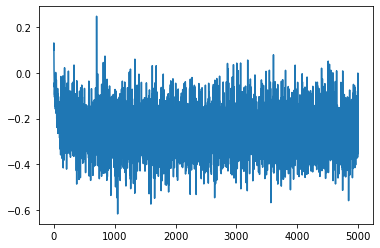

In [37]:
plt.plot(ll_trn)
tf.reduce_mean(gmcm_obj.distribution.log_prob(ss))

In [58]:
gmcm_obj.gmc.distribution.log_prob(np.array([0.3,0.1]).astype('float32').reshape(1,-1))

def target_log_prob(u_part):
    u = tf.concat([u_part,tf.constant(0.999999,shape=(1,))],axis=0)
    u = tf.reshape(u,shape=(1,-1))
    return gmcm_obj.gmc.distribution.log_prob(u)

init_state = tf.constant(np.random.rand(1).astype('float32'))
target_log_prob(init_state)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-2.7199116], dtype=float32)>

In [24]:
# init_state = tf.constant(np.random.rand(2).astype('float32'))
u_init = tf.Variable(init_state)
with tf.GradientTape() as tape:
    out = target_log_prob(u_init)
grads = tape.gradient(out, u_init)
print(out)
print(grads)

grad_fd = gradientFiniteDifferent(target_log_prob,u_init,delta=1E-4)
print(grad_fd)

tf.Tensor([-0.6234164], shape=(1,), dtype=float32)
tf.Tensor([0. 0.], shape=(2,), dtype=float32)
[-16.32452011 -93.01185608]


In [32]:
# Running 5 chains in parallel
n_chains = 5
init_state = tf.constant(np.random.rand(2).astype('float32'))
step_size= 0.1
# bijector to map contrained parameters to real
ts = time.time()
output_NUTS = run_chain(init_state, step_size, target_log_prob,num_steps=10,burnin=50)
print(f'NUTS runtime for {n_chains} chains: {time.time()-ts} s.')

C:\Users\tewar\Anaconda3\envs\myPythonEnv\lib\site-packages\tensorflow_probability\python\mcmc\sample.py:342: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


NUTS runtime for 5 chains: 7.9406280517578125 s.


In [ ]:
ess = tfp.mcmc.effective_sample_size(output_NUTS.all_states)
ess = tfp.transpose(ess).numpy()
plot(ess)
total_samples_all_chains = np.prod(output_NUTS.all_states.shape[:2])
total_samples = tf.reshape(output_NUTS.all_states,shape=(total_samples_all_chains,2))

In [33]:
output_NUTS.all_states

<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[ 0.01819915, -0.52441907],
       [ 0.01819915, -0.52441907],
       [ 0.01819915, -0.52441907],
       [ 0.01819915, -0.52441907],
       [ 0.01819915, -0.52441907],
       [ 0.01819915, -0.52441907],
       [ 0.01819915, -0.52441907],
       [ 0.01819915, -0.52441907],
       [ 0.01819915, -0.52441907],
       [ 0.01819915, -0.52441907]], dtype=float32)>

In [59]:
u_vec = np.linspace(0.001,0.9999,50).astype('float32').reshape(-1,1)
p_vec = np.zeros(50)
for i in range(50):
    p_vec[i] = target_log_prob(u_vec[i])
    if i%10 ==0:
        print(i)


0
10
20
30
40


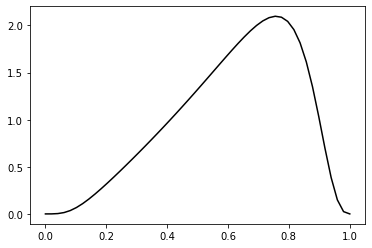

In [60]:
plt.plot(u_vec,tf.exp(p_vec),'k')